In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import math

# set plot parameters
plt.rcParams.update({'font.size': 16})
plt.rcParams['text.usetex'] = True

## Define Kalman filter and fix-lag smoother classes

In [2]:
# deine fix lag smoothing class
class FixLagSmoother:
    def __init__(self, N, A, Q, C, R, x, P):
        self.N = N # lag window size
        self.x = x # initial state
        self.P = P # initial state covariance matrix
        self.A = A # train matrix
        self.Q = Q # transition covariance matrix
        self.C = C # observation matrix
        self.R = R # observation covariance matrix
        # self.x_pred = [x] # predicted state
        # self.P_pred = [P] # predicted state covariance matrix
        self.x_smooth = [] # smoothed state
        self.Sigma_smooth = [] # smoothed state covariance matrix
        
        self.count = 0 # counter
        
    def smooth(self, z):
        self.z =z # observation data
        
        k = self.count
        
        # predict step of KF (a priori estimate)
        x_pred = self.A @ self.x # predicted state
        P_pred = self.A @ self.P @ self.A.T + self.Q # predicted state covariance matrix
        
        # self.x_pred.append(x_pred.copy())
        # self.P_pred.append(P_pred.copy())
        
        # update step of KF (a posteriori estimate)
        K = P_pred @ self.C.T @ np.linalg.pinv(self.C @ P_pred @ self.C.T + self.R) # Standard Kalman gain
        x_filt = x_pred + K @ (self.z - self.C @ x_pred) # filtered state
        P_filt = P_pred - K @ self.C @ P_pred# filtered state covariance matrix
        
        self.x_smooth.append(x_pred.copy())
        self.Sigma_smooth.append(P_pred.copy())
        
        # apply smoothing
        if k >= self.N:
            # P_smooth = P_pred.copy()
            # for i in range(self.N):
            #     K_i = P_smooth @ self.C.T @ np.linalg.pinv(self.C @ P_pred @ self.C.T + self.R) # smooth Kalman gain
            #     P_smooth = P_smooth @ (self.A - K @ self.C).T 
            # 
            #     si = k-i # index of smoothed state
            #     self.x_smooth[si] = self.x_smooth[si] + K_i @ (self.z - self.C @ x_pred) # smoothed state
            #     self.Sigma_smooth[si] = self.Sigma_smooth[si] - P_smooth @ C.T @ K_i.T # smooth state covariance matrix
            # 
            for i in range(self.N):
                si = k-i # index of smoothed state

                K_i = self.Sigma_smooth[si] @ self.C.T @ np.linalg.pinv(self.C @ P_pred @ self.C.T + self.R) # smooth Kalman gain
                P_smooth = self.Sigma_smooth[si] @ (self.A - K @ self.C).T 

                self.x_smooth[si] = self.x_smooth[si] + K_i @ (self.z - self.C @ x_pred) # smoothed state
                self.Sigma_smooth[si] = self.Sigma_smooth[si] - P_smooth @ C.T @ K_i.T # smooth state covariance matrix
           
        else:
            self.x_smooth[k] = x_filt.copy()
            self.Sigma_smooth[k] = P_filt.copy()
            
        self.count += 1
        self.x = x_filt.copy()
        self.P = P_filt.copy()

In [3]:
# define Kalman filter class
class KalmanFilter:
    def __init__(self, A, Q, C, R, x, P):
        self.x = x # initial state
        self.P = P # initial state covariance matrix
        self.A = A # train matrix
        self.Q = Q # transition covariance matrix
        self.C = C # observation matrix
        self.R = R # observation covariance matrix
        self.x_filt = [x] # filtered state
        self.P_filt = [P] # filtered state covariance matrix
        self.x_pred = [x] # predicted state
        self.P_pred = [P] # predicted state covariance matrix
        self.x_smooth = [] # smoothed state
        self.P_smooth = [] # smoothed state covariance matrix
        
    def filter(self, z):
        self.z = z # observation data
        
        # predict step of KF
        x_ = self.A @ self.x # predicted state
        P_ = self.A @ self.P @ self.A.T + self.Q # predicted state covariance matrix
        
        self.x_pred.append(x_.copy())
        self.P_pred.append(P_.copy())
        
        # update step of KF
        K = P_ @ self.C.T @ np.linalg.pinv(self.C @ P_ @ self.C.T + self.R) # Kalman gain
        x_filt = x_ + K @ (self.z - self.C @ x_) # filtered state
        P_filt = (np.identity(np.size(C)) - K @ C) @ P_ # filtered state covariance matrix
        
        self.x_filt.append(x_filt.copy())
        self.P_filt.append(P_filt.copy())
        
        self.x = x_filt.copy()
        self.P = P_filt.copy()
        
    def smooth(self):
        # apply RTS smoother
        self.x_smooth = self.x_filt.copy()
        self.P_smooth = self.P_filt.copy()
        for i in range(len(self.x_filt)-2, -1, -1):
                J = self.P_filt[i] @ self.A.T @ np.linalg.pinv(self.P_pred[i+1])
                self.x_smooth[i] = self.x_filt[i] + J @ (self.x_smooth[i+1] - self.x_pred[i+1])
                self.P_smooth[i] = self.P_filt[i] + J @ (self.P_smooth[i+1] - self.P_pred[i+1]) @ J.T
            

In [4]:
# define parameters
N = 10 # lag window size
A = np.array([[1, 1], [0, 1]]) # train matrix
Q = np.array([[0.25, 0.5], [0.5, 1]]) * 0.1**2 # transition covariance matrix
C = np.array([[1, 0]]) # observation matrix
R = np.array([[3]]) # observation covariance matrix

x = np.array([1, -1]) # initial state
P = np.array([[2**2, 0],
                          [0, 1.5**2]]) # initial state covariance matrix

## Generate data

In [5]:
# generate data
np.random.seed(0)
n = 50
t = np.linspace(0, n, n)
z = t + np.random.normal(0, R[0], n)

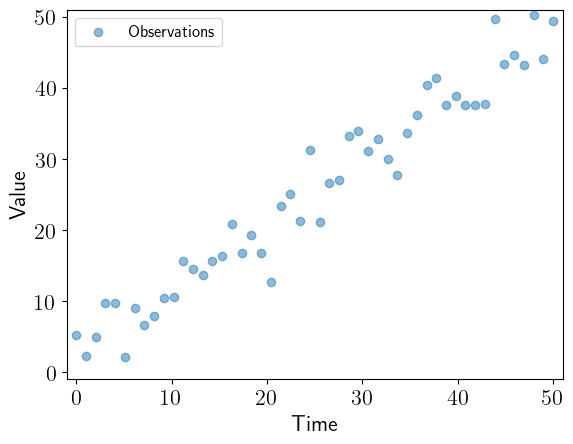

In [6]:
# plot data
plt.scatter(t, z, label='Observations', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(-1, n+1)
plt.ylim(-1, n+1)
plt.legend(loc= 'upper left', fontsize=12)
plt.savefig('Observations.png', dpi=300, bbox_inches='tight')


## Fix-lag smoother

In [7]:
# create smoother object
lag_smoother = FixLagSmoother(N, A, Q, C, R, x, P)

In [8]:
# smooth data
for obs in z:
    lag_smoother.smooth(obs)

In [9]:
xlag_smooth = np.array(lag_smoother.x_smooth)[:, 0]
Plag_smooth = np.array(lag_smoother.Sigma_smooth)[:, 0, 0]

## Kalman filter

In [10]:
# create Kalman filter object
kf = KalmanFilter(A, Q, C, R, x, P)

In [11]:
# filter data
for obs in z:
    kf.filter(obs)

In [12]:
x_filt = np.array(kf.x_filt)[:, 0]
P_filt = np.array(kf.P_filt)[:, 0, 0]

## RTS smoother

In [13]:
# create RTS smoother object
kf.smooth()

In [14]:
# smooth data
x_smooth = np.array(kf.x_smooth)[:, 0]
P_smooth = np.array(kf.P_smooth)[:, 0, 0]

## Plot Results

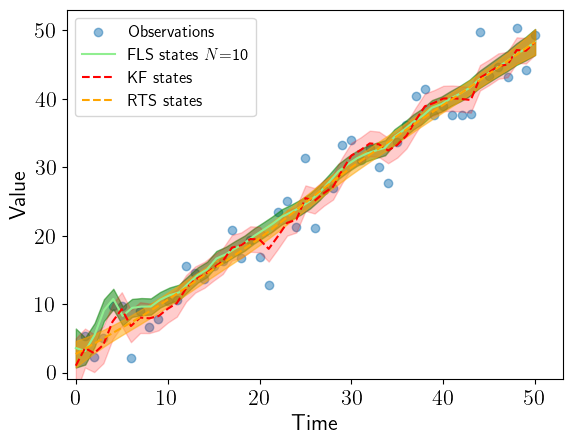

In [15]:
# plot data
plt.scatter(range(1,len(t)+1), z, label='Observations', alpha=0.5)
plt.plot(t, xlag_smooth, label='FLS states $N$='+str(N), color='lightgreen')
plt.fill_between(t, xlag_smooth - 2*np.sqrt(Plag_smooth), xlag_smooth + 2*np.sqrt(Plag_smooth), color='green', alpha=0.5)
plt.plot(range(len(t)+1), x_filt, label='KF states', linestyle='--', color='red')
plt.fill_between(range(len(t)+1), x_filt - 2*np.sqrt(P_filt), x_filt + 2*np.sqrt(P_filt), color='red', alpha=0.2)
plt.plot(range(len(t)+1), x_smooth, label='RTS states', linestyle='--', color='orange')
plt.fill_between(range(len(t)+1), x_smooth - 2*np.sqrt(P_smooth), x_smooth + 2*np.sqrt(P_smooth), color='orange', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(-1, n+3)
plt.ylim(-1, n+3)
# location of legend is outside the plot
plt.legend(loc='upper left', fontsize=12)
plt.savefig('Results.png', dpi=300, bbox_inches='tight')

In [16]:
# get MSE of smoothed data
mse_smooth = np.mean((x_smooth[1:] - t)**2)
print(f'MSE of smoothed data: {round(mse_smooth,4)}')

# get MSE of filtered data
mse_filt = np.mean((x_filt[1:] - t)**2)
print(f'MSE of filtered data: {round(mse_filt, 4)}')

# get MSE of lag smoothed data
mse_lag_smooth = np.mean((xlag_smooth - t)**2)
print(f'MSE of lag smoothed data: {round(mse_lag_smooth, 4)}')

MSE of smoothed data: 1.747
MSE of filtered data: 2.8715
MSE of lag smoothed data: 3.4158


## Experiment with N

In [17]:
# iterate over different lag window sizes and get MSE
MSE = []
for N in range(1, 30):
    lag_smoother = FixLagSmoother(N, A, Q, C, R, x, P)
    for obs in z:
        lag_smoother.smooth(obs)
    xlag_smooth = np.array(lag_smoother.x_smooth)[:, 0]
    mse_lag_smooth = np.mean((xlag_smooth - t)**2)
    MSE.append(mse_lag_smooth)

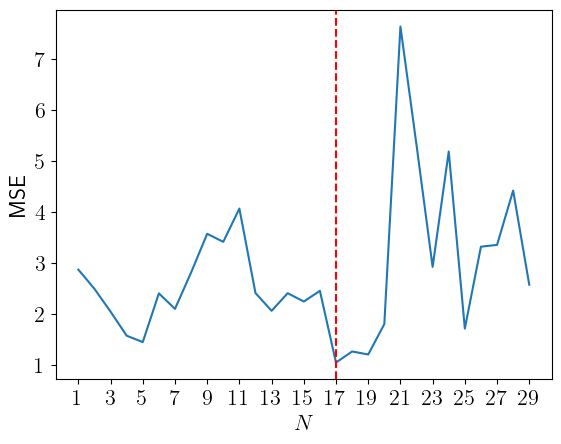

In [18]:
# plot MSE
plt.plot(range(1, 30), MSE)

 # N written as latex equation for x labek
plt.xlabel(r'${N}$')
plt.ylabel('MSE')
plt.xticks(range(1, 30, 2))

plt.axvline(np.argmin(MSE)+1, color='red', linestyle='--')
plt.savefig('N_optimal.png', dpi=300, bbox_inches='tight')

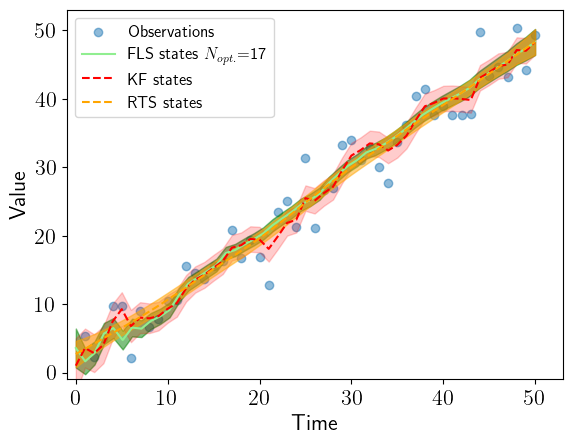

In [19]:
# get optimal N
optimal_N = np.argmin(MSE)+1

# aplly fix-lag smoother with optimal N
lag_smoother = FixLagSmoother(optimal_N, A, Q, C, R, x, P)
for obs in z:
    lag_smoother.smooth(obs)
xlag_smooth = np.array(lag_smoother.x_smooth)[:, 0]
Plag_smooth = np.array(lag_smoother.Sigma_smooth)[:, 0, 0]

# plot data
plt.scatter(range(1,len(t)+1), z, label='Observations', alpha=0.5)
plt.plot(t, xlag_smooth, label='FLS states $N_{opt.}$='+str(optimal_N), color='lightgreen')
plt.fill_between(t, xlag_smooth - 2*np.sqrt(Plag_smooth), xlag_smooth + 2*np.sqrt(Plag_smooth), color='green', alpha=0.5)
plt.plot(range(len(t)+1), x_filt, label='KF states', linestyle='--', color='red')
plt.fill_between(range(len(t)+1), x_filt - 2*np.sqrt(P_filt), x_filt + 2*np.sqrt(P_filt), color='red', alpha=0.2)
plt.plot(range(len(t)+1), x_smooth, label='RTS states', linestyle='--', color='orange')
plt.fill_between(range(len(t)+1), x_smooth - 2*np.sqrt(P_smooth), x_smooth + 2*np.sqrt(P_smooth), color='orange', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(-1, n+3)
plt.ylim(-1, n+3)
# location of legend is outside the plot
plt.legend(loc='upper left', fontsize=12)
plt.savefig('Optimal_smoothing.png', dpi=300, bbox_inches='tight')

In [20]:
# get MSE of optimal smoothed data
mse_smooth = np.mean((xlag_smooth - t)**2)
print(f'MSE of optimal smoothed data: {round(mse_smooth, 4)}')

MSE of optimal smoothed data: 1.0494


## Experiment with different observation noise and N

In [21]:
# generate multiple datasets with different observation noise
Z = []
# generate data
np.random.seed(0)

R = np.array([0.1, 0.5, 1, 2, 5, 10])
n = 100
t = np.linspace(0, n, n)

for r in R:
    Z.append(t + np.random.normal(0, r, n)) 

(-1.0, 101.0)

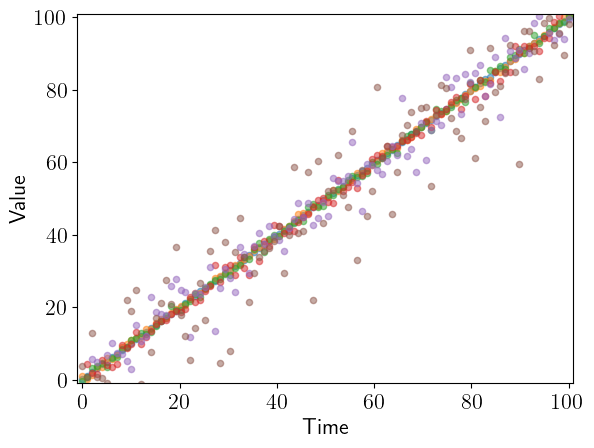

In [22]:
# plot data
for z in Z:
    plt.scatter(t, z, label='Observations', alpha=0.5, s=20)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(-1, n+1)
plt.ylim(-1, n+1)

In [23]:
# run fixed lag smoother for different observation noise and N 
# and collect optimal N for each dataset
optimal_Ns = []

for z, r in zip(Z, R):
    MSE = []
    for N in range(1, 20):
        
        lag_smoother = FixLagSmoother(N, A, Q, C, r, x, P)
        for obs in z:
            lag_smoother.smooth(obs)
            
        xlag_smooth = np.array(lag_smoother.x_smooth)[:, 0]
        mse_lag_smooth = np.mean((xlag_smooth - t)**2)
        MSE.append(mse_lag_smooth)
    optimal_N = np.argmin(MSE)+1
    optimal_Ns.append(optimal_N)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/2n/rgg8qrjd2dv0zkx0bktfvk2h0000gn/T/ipykernel_18700/1390741214.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$$\sigma^2_{R}$$')


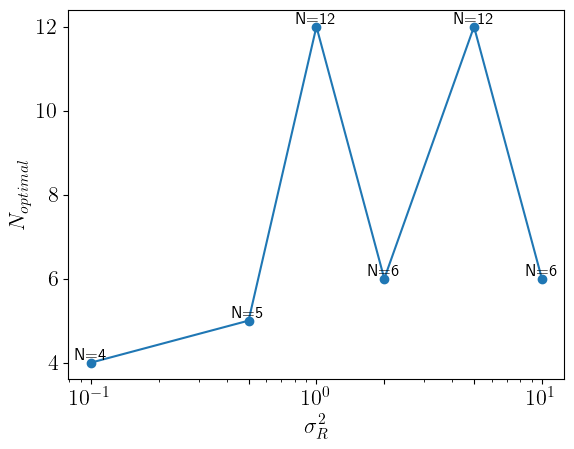

In [24]:
# plot optimal N for each value of observation noise
plt.plot(R, optimal_Ns, marker='o')
plt.xlabel('$$\sigma^2_{R}$$')
plt.ylabel('$$N_{optimal}$$')
plt.xscale('log')
plt.xticks(R)
for r, N in zip(R, optimal_Ns):
    plt.text(r, N, f'N={N}', fontsize=12, ha='center', va='bottom')
# plt.savefig('Optimal_N.png', dpi=300, bbox_inches='tight')